# Assignment 2 - Randomized Optimization - mkecera3@gatech.edu

In [1]:
# imports
import mlrose
import numpy as np
import time
import itertools
import pandas as pd
import seaborn as sns
save_path = './charts/'

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## 4-peaks

In [ ]:
# define the 4-peaks problem and print an example
fitness = mlrose.FourPeaks(t_pct=0.1)
state = np.array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 100, fitness_fn = fitness, maximize = True, max_val = 2)

In [ ]:
def parameter_search(problem, algorithm, **kwargs):
    
    values = []
    names = []
    for key, value in kwargs.items():
        names.append(key)
        values.append(value)
    
    permutations = [(x, y) for x in values[0] for y in values[1]]
    param1 = [x[0] for x in permutations]
    param2 = [x[1] for x in permutations]

    all_states = []
    all_fitness = []
    all_curves = []
    run_times = []
    for permutation in permutations:
        start_time = time.time()
        param = {}
        param[names[0]] = permutation[0]
        param[names[1]] = permutation[1]
        best_state, best_fitness, curve = algorithm(
            problem=problem,
            curve=True,
            **param
            )
        end_time = time.time()
        run_time = end_time - start_time
        
        all_states.append(best_state)
        all_fitness.append(best_fitness)
        run_times.append(run_time)
        all_curves.append(curve)

    return all_states, all_fitness, all_curves, run_times, param1, param2

### Randomized hill climbing

In [ ]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "4p_rhc_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "4p_rhc_hyperparam.png", dpi=100)

### Simulated annealing

In [ ]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "4p_sa_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "4p_sa_hyperparam.png", dpi=100)

### Genetic Algorithm

In [ ]:
pop_size = list(np.geomspace(200, 20000, 8))
mut_prob = list(np.linspace(0, 0.5, 8))
pop_size = [int(x) for x in pop_size]
mut_prob = [round(x, 2) for x in mut_prob]

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "4p_ga_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "4p_ga_hyperparam.png", dpi=100)

### MIMIC

In [ ]:
pop_size = list(np.geomspace(50, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percantage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "mimic_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "mimic_hyperparam.png", dpi=100)

## Knapsack

In [ ]:
# define the Knapsack problem and print an example
value = [1, 5, 10, 20, 5, 1, 10, 5, 8]
weight = [5, 5, 15, 7, 12, 10, 20, 1, 7]
max_weight = 0.6
fitness = mlrose.Knapsack(weights=weight, values=value, max_weight_pct=max_weight)
state = np.array([1, 0, 1, 0, 1, 0, 0, 1, 0])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 9, fitness_fn = fitness, maximize = True, max_val = 2)

### Randomized hill climbing

In [ ]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "ks_rhc_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "ks_rhc_hyperparam.png", dpi=100)

### Simulated Annealing

In [ ]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "ks_sa_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "ks_sa_hyperparam.png", dpi=100)

### Genetic Algorithm

In [ ]:
pop_size = list(np.geomspace(200, 20000, 8))
mut_prob = list(np.linspace(0, 0.5, 8))
pop_size = [int(x) for x in pop_size]
mut_prob = [round(x, 2) for x in mut_prob]

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "ks_ga_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "ks_ga_hyperparam.png", dpi=100)

### MIMIC

In [ ]:
pop_size = list(np.geomspace(500, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percantage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

## Count ones

In [ ]:
# define the Count ones problem and print an example
fitness = mlrose.OneMax()
state = np.random.choice([0, 1], size=100, p=[0.5, 0.5])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 100, fitness_fn = fitness, maximize = True, max_val = 2)

### Randomized hill climbing

In [ ]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "co_rhc_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing')
sns_plot.get_figure().savefig(save_path + "co_rhc_hyperparam.png", dpi=100)

### Simulated Annealing

In [ ]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [ ]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "co_sa_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing')
sns_plot.get_figure().savefig(save_path + "co_sa_hyperparam.png", dpi=100)

### Genetic Algorithm

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "co_ga_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms')
sns_plot.get_figure().savefig(save_path + "co_ga_hyperparam.png", dpi=100)

### MIMIC

In [ ]:
pop_size = list(np.geomspace(50, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [ ]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

In [ ]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percantage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

In [ ]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

# Neural Network

## Dataset

In [ ]:
# load dataset
creditDataDf = pd.read_excel('./data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])
dfColumns = creditDataDf.columns

# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [ ]:
print(X_train.columns)
print(len(X_train.columns))
print(sum(y_train)/len(y_train))

In [ ]:
y_train

In [ ]:
# The following code was adapted from https://mlrose.readthedocs.io/en/stable/source/tutorial3.html
# Initialize neural network object and fit object
nn_model = mlrose.NeuralNetwork(
    hidden_nodes = [25, 15], 
    activation = 'relu',
    algorithm = 'gradient_descent', 
    max_iters = 10000,
    bias = False, 
    is_classifier = True, 
    learning_rate = 0.0001,
    early_stopping = True, 
    clip_max = 50, 
    max_attempts = 1000,
    random_state = 3,
    restarts=10
    )

nn_model.fit(X_train, y_train)

In [ ]:
# Predict labels for train set and assess accuracy
y_train_pred = nn_model.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

In [ ]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [ ]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

In [ ]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [ ]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
            print(rows.float())
            output = model2(rows)
            loss = criterion(output, labels)
            running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [ ]:
input_size = 30
hidden_sizes = [2]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    # nn.ReLU(),
    # nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    # nn.ReLU(),
    # nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [ ]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time.time()
    epochs = 100
    lossData = []
    accData=[]
    runTime = []
    for e in range(epochs):
        startTime = time.time()
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])

        runTime.append(time.time() - startTime)
    
    return lossData, accData, runTime
        
    print("\nTraining Time (in minutes) =",(time.time()-time0)/60)

In [ ]:
def NN_fitness_function(state, model):
    time0 = time.time()
    lossData = []
    accData=[]
    runTime = []
    startTime = time.time()

    l1 = torch.tensor(np.reshape(state[0:60], (2, 30)).astype(np.float32))
    # l2 = torch.tensor(np.reshape(state[750:1125], (15, 25)).astype(np.float32))
    # l3 = torch.tensor(np.reshape(state[1125:1155], (2, 15)).astype(np.float32))
    # print(model[4].weight)
    # print(torch.nn.Parameter(l3))

    with torch.no_grad():
        model[0].weight = torch.nn.Parameter(l1)
        # model[2].weight = torch.nn.Parameter(l2)
        # model[4].weight = torch.nn.Parameter(l3)
        
    testingLoss, correctCount, allCount, proba = nnPredictTabular(model, trainloader2, criterion)
    print("Loss  =", (testingLoss))
    # print("Accuracy  =", (correctCount / allCount))
    
    # lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
    # lossData.append([e, testingLoss, 'Testing Loss'])
    # accData.append([e, correctCount / allCount])

    # runTime.append(time.time() - startTime)
    
    return testingLoss

In [ ]:
fitnessNN = mlrose.CustomFitness(NN_fitness_function, model=modelTabBaseline)

In [ ]:
state = list(np.random.uniform(-0.1, 0.1, 60))
fitnessNN.evaluate(state)

In [ ]:
problem = mlrose.ContinuousOpt(
    length = 60, 
    fitness_fn = fitnessNN, 
    maximize = False, 
    min_val=-0.1, 
    max_val = 0.1,
    step=0.0001
    )

In [ ]:
# Define decay schedule
schedule = mlrose.ExpDecay()

best_state, best_fitness = mlrose.random_hill_climb(
    problem, 
    # schedule = schedule,
    max_attempts = 10, 
    max_iters = 1000,
    init_state = state, 
    random_state = 1)

In [ ]:
lossDataBaseline, accDataBaseline, runtime = trainTabNN(modelTabBaseline)

In [ ]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [ ]:
correctCount/allCount

In [ ]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
sns.set(
    style="darkgrid"
    )

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('NN')
# sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

In [ ]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('NN')

## MNIST

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

train_sampler = torch.utils.data.sampler.RandomSampler(trainset, replacement=True, num_samples=5000)
val_sampler = torch.utils.data.sampler.RandomSampler(valset, replacement=True, num_samples=5000)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, sampler=val_sampler)

In [6]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [87]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [88]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [89]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time.time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time.time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time.time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time.time()-time0)/60)

In [90]:
def trainNN_randomized_hill_climbing(model, stdev, restarts, max_iter):
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time.time()
    # epochs = epochs
    lossData = []
    accData = []
    runTime = []
    previous_loss = 999
    run = True
    iteration = 0
    restarted = 0
    total_iterations = 0
    update_ls = True
    best_loss_across = 999

    best_w1 = model[0].weight
    best_w2 = model[2].weight
    best_w3 = model[4].weight

    while run:
        startTime = time.time()
        running_loss = 0

        state = np.random.normal(0, stdev, 109184)

        l1 = torch.tensor(np.reshape(state[0:100352], (128, 784)).astype(np.float32))
        l2 = torch.tensor(np.reshape(state[100352:108544], (64, 128)).astype(np.float32))
        l3 = torch.tensor(np.reshape(state[108544:109184], (10, 64)).astype(np.float32))
        # print(l1.shape)
        # print(torch.nn.Parameter(l3))

        with torch.no_grad():
            orig_w1 = model[0].weight
            orig_w2 = model[2].weight
            orig_w3 = model[4].weight

        with torch.no_grad():
            model[0].weight = torch.nn.Parameter(model[0].weight + l1)
            model[2].weight = torch.nn.Parameter(model[2].weight + l2)
            model[4].weight = torch.nn.Parameter(model[4].weight + l3)

        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
        else:
            current_loss = running_loss/len(trainloader)
            # print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

        print(
            'Restarted: ' + str(restarted),
            'Iteration: ' + str(iteration), 
            'Previous loss: ' + str(round(previous_loss, 3)), 
            'Current loss: ' + str(round(current_loss, 3)),
            'Best loss: ' + str(round(best_loss_across, 3))
            )
        
        if current_loss > previous_loss:
            iteration += 1
            with torch.no_grad():
                model[0].weight = orig_w1
                model[2].weight = orig_w2
                model[4].weight = orig_w3
            
            if iteration > max_iter:

                restarted += 1

                if previous_loss < best_loss_across:
                    best_w1 = model[0].weight
                    best_w2 = model[2].weight
                    best_w3 = model[4].weight
                    best_loss_across = previous_loss
                    previous_loss = 999

                new_weights = np.random.normal(0, 0.01, 109184)
                n1 = torch.tensor(np.reshape(new_weights[0:100352], (128, 784)).astype(np.float32))
                n2 = torch.tensor(np.reshape(new_weights[100352:108544], (64, 128)).astype(np.float32))
                n3 = torch.tensor(np.reshape(new_weights[108544:109184], (10, 64)).astype(np.float32))

                model[0].weight = torch.nn.Parameter(n1)
                model[2].weight = torch.nn.Parameter(n2)
                model[4].weight = torch.nn.Parameter(n3)

                iteration = 0

                if restarted > restarts:
                    run = False
                    model[0].weight = best_w1
                    model[2].weight = best_w2
                    model[4].weight = best_w3
        else:
            previous_loss = current_loss
            # best_w1 = model[0].weight
            # best_w2 = model[2].weight
            # best_w3 = model[4].weight
            
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        # print("Testing Loss  =", (testingLoss))
        
        lossData.append([total_iterations, running_loss/len(trainloader), 'Training Error'])
        lossData.append([total_iterations, testingLoss, 'Testing Error'])
        accData.append([total_iterations, correctCount / allCount])

        runTime.append(time.time() - startTime)
        total_iterations += 1

        # print(model[0].weight)
    
    return lossData, accData, runTime    

In [91]:
lossDataBaseline, accDataBaseline, runtime = trainNN_randomized_hill_climbing(model, 0.01, 10, 2000)

.601 Current loss: 2.304 Best loss: 1.563
Restarted: 5 Iteration: 1871 Previous loss: 1.601 Current loss: 2.302 Best loss: 1.563
Restarted: 5 Iteration: 1872 Previous loss: 1.601 Current loss: 2.303 Best loss: 1.563
Restarted: 5 Iteration: 1873 Previous loss: 1.601 Current loss: 2.301 Best loss: 1.563
Restarted: 5 Iteration: 1874 Previous loss: 1.601 Current loss: 2.301 Best loss: 1.563
Restarted: 5 Iteration: 1875 Previous loss: 1.601 Current loss: 2.302 Best loss: 1.563
Restarted: 5 Iteration: 1876 Previous loss: 1.601 Current loss: 2.302 Best loss: 1.563
Restarted: 5 Iteration: 1877 Previous loss: 1.601 Current loss: 2.301 Best loss: 1.563
Restarted: 5 Iteration: 1878 Previous loss: 1.601 Current loss: 2.303 Best loss: 1.563
Restarted: 5 Iteration: 1879 Previous loss: 1.601 Current loss: 2.301 Best loss: 1.563
Restarted: 5 Iteration: 1880 Previous loss: 1.601 Current loss: 2.303 Best loss: 1.563
Restarted: 5 Iteration: 1881 Previous loss: 1.601 Current loss: 2.301 Best loss: 1.563
R

KeyboardInterrupt: 

In [39]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [40]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

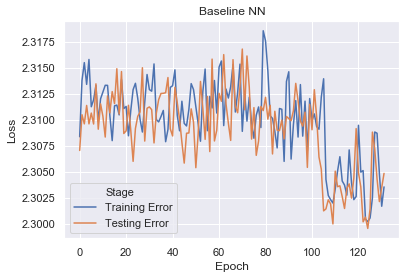

In [41]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
# sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

In [42]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

DataError: No numeric types to aggregate

In [32]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [33]:
correctCount / allCount

0.1554

In [ ]:
def NN_fitness_function(state, model):
    time0 = time.time()
    lossData = []
    accData=[]
    runTime = []
    startTime = time.time()

    l1 = torch.tensor(np.reshape(state[0:100352], (128, 784)).astype(np.float32))
    l2 = torch.tensor(np.reshape(state[100352:108544], (64, 128)).astype(np.float32))
    l3 = torch.tensor(np.reshape(state[108544:109184], (10, 64)).astype(np.float32))
    # print(l1.shape)
    # print(torch.nn.Parameter(l3))

    with torch.no_grad():
        model[0].weight = torch.nn.Parameter(l1)
        model[2].weight = torch.nn.Parameter(l2)
        model[4].weight = torch.nn.Parameter(l3)
        
    testingLoss, correctCount, allCount = nnPredict(model, trainloader, criterion)
    print("Loss  =", (testingLoss))
    # print("Accuracy  =", (correctCount / allCount))
    
    # lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
    # lossData.append([e, testingLoss, 'Testing Loss'])
    # accData.append([e, correctCount / allCount])

    # runTime.append(time.time() - startTime)
    
    return testingLoss

In [ ]:
fitnessNN = mlrose.CustomFitness(NN_fitness_function, model=model)

In [ ]:
state = list(np.random.uniform(-0.1, 0.1, 109184))
fitnessNN.evaluate(state)

In [ ]:
problem = mlrose.ContinuousOpt(
    length = 109184, 
    fitness_fn = fitnessNN, 
    maximize = False, 
    min_val=-0.1, 
    max_val = 0.1,
    step=0.0001
    )

In [ ]:
# Define decay schedule
schedule = mlrose.ExpDecay()

best_state, best_fitness = mlrose.random_hill_climb(
    problem, 
    # schedule = schedule,
    max_attempts = 10, 
    max_iters = 3000,
    init_state = state,
    restarts = 20, 
    random_state = 1)

In [ ]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [ ]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [ ]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [ ]:
X_train_MNIST = X_train_MNIST[0:4000]
X_test_MNIST = X_test_MNIST[0:4000]
y_train_MNIST = y_train_MNIST[0:4000]
y_test_MNIST = y_test_MNIST[0:4000]

In [ ]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

In [ ]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((4000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((4000, 784))

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_MNIST_reshaped)
X_test_scaled = scaler.transform(X_test_MNIST_reshaped)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train_MNIST.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test_MNIST.reshape(-1, 1)).todense()

In [ ]:
# The following code was adapted from https://mlrose.readthedocs.io/en/stable/source/tutorial3.html
# Initialize neural network object and fit object
nn_model = mlrose.NeuralNetwork(
    hidden_nodes = [100], 
    activation = 'relu',
    algorithm = 'random_hill_climb', 
    max_iters = 1000,
    bias = True, 
    is_classifier = True, 
    learning_rate = 0.001,
    early_stopping = True, 
    clip_max = 5, 
    max_attempts = 100,
    random_state = 3,
    restarts=20
    )

nn_model.fit(X_train_scaled, y_train_hot)

In [ ]:
# Predict labels for train set and assess accuracy
y_train_pred = nn_model.predict(X_train_scaled)
y_train_accuracy = accuracy_score(y_train_pred, y_train_hot)
print(y_train_accuracy)

In [ ]:
# Predict labels for train set and assess accuracy
y_test_pred = nn_model.predict(X_test_scaled)
y_test_accuracy = accuracy_score(y_test_pred, y_test_hot)
print(y_test_accuracy)